# The bacterial diffusion in a toxic environment model

Our goal is to simulate the bacterial movement in a environment where a toxic substance whose concentration is $S$ is spreading. That could represent the action of a antibiotic or a leak of some chemical, for example. Our model goes as following:

\begin{align}
    \mathrm{model} = \begin{cases}
        \displaystyle \frac{\partial \rho}{\partial t} = D_b \frac{\partial^2 \rho}{\partial x^2} + r \rho - \gamma \rho^2 + \frac{\partial}{\partial x}\left( \rho \frac{\partial S}{\partial x} \right) \color{red}{ + \text{ ?}} \\
        \displaystyle \frac{\partial S}{\partial t} = D_s \frac{\partial^2 S}{\partial x^2} - \lambda S\color{red}{\rho + \text{ ?}}
    \end{cases}
\end{align}

where the terms in red are not yet being considered and the ? represents terms that will later be added to represent the bacterial death by consumption of the substance and substance depletion due to bacterial consumption, $\rho$ is the density of a substance and $D_b$ and $D_s$ are the diffusion coefficients of the bacteria and the substance, respectively.

In order to simulate this equation we must pass from a continuous equation to a discrete equation, since continuous variables is not a computational reality. Thus, our simulation is taken in timesteps of size $\Delta t$, where the step in time must not be larger than

\begin{align}
    \Delta t \leq \frac{\left( \Delta x \right)^2}{2 \alpha}
\end{align}

being $\Delta x$ the step in space, that is, the minimum unit of division of our space (we are working on 1 dimensional, so dividing our space in spatial steps is easier).

When working in discrete time and space, the differential operators $\partial$ become only spatial or temporal differences ($\partial t \rightarrow \Delta t$, for example). This way, the left hand side of the heat diffusion equation is written as

\begin{align}
    \frac{\Delta \rho}{\Delta t}
\end{align}

since $\alpha$ is a constant, it does not change when we move from continuous systems to discrete systems. Ok, now to the second derivative term... remember that $\partial^2/\partial x^2$ is not a derivative squared, is the application of a derivative on top of a derivative, formaly it means

\begin{align}
    & \frac{\partial^2}{\partial x^2} = \frac{\partial}{\partial x} \left( \frac{\partial}{\partial x} \right) \\
    & \frac{\partial^2}{\partial x^2} \neq \left( \frac{\partial}{\partial x} \right)^2
\end{align}

In reality, we are computing the rate of change of the spatial change. So the second derivative is written

\begin{align}
    \frac{\partial^2 \rho}{\partial x^2} \rightarrow \frac{\rho_{i+1} - 2\rho_{i} + \rho_{i-1}}{\Delta x^2}
\end{align}

Thus, the final equation in discrete time and space is

\begin{align}
    \frac{\rho_i^{t+1} - \rho_i^t}{\Delta t} = D_b \frac{\rho_{i+1}^t - 2\rho_{i}^t + \rho_{i-1}^t}{\Delta x^2} = D_b \left[ -\frac{\left( \rho_i^t - \rho_{i-1}^t \right)}{\Delta x^2} - \frac{\left( \rho_{i+1}^t - \rho_{i}^t \right)}{\Delta x^2} \right]  + r \rho_i^t - \gamma \rho_i^t
\end{align}

We then compute the density $\rho_{i}^{t+1}$ simply by

\begin{align}
    \rho_i^{t+1} & = \rho_i^t + \Delta t \left[ D_b \left[ -\frac{\left( \rho_i^t - \rho_{i-1}^t \right)}{\Delta x^2} - \frac{\left( \rho_{i+1}^t - \rho_{i}^t \right)}{\Delta x^2} \right] + r \rho_i^t - \gamma \rho_i^t + \right. \\
    & \left. + \chi \left[ \frac{ (\rho_{i}^t - \rho_{i-1}^t)(S_{i}^t - S_{i-1}^t)}{\Delta x^2} + \rho_{i}^t \left( \frac{S_{i+1}^t - 2 S_{i}^t + S_{i-1}^t}{\Delta x^2} \right) \right] \right]
\end{align}

Let's simulate this using the following libraries ```numpy```, ```scipy``` and ```matplotlib```. We can do it using only ```numpy``` actually, ```matplotlib``` will be used only to plot the result and ```scipy``` only to write our initial condition. We will consider as a initial condition, that is the value of $\rho_i$ when $t=0$, $\rho_i^0 = \mathrm{Gaussian}(x_i)$. We will be starting with a normal distribution of density, and we will see what happens to this density distribution as time passes. The ```scipy``` library will be used to define this, altough we could define it using ```numpy``` as well, I just want to speed things up.

I will be also importing the libaries ```warnings```, ```seaborn``` and ```tqdm```. But they are not used to solve the equation, they are just to ignore any warning, get beautiful color palettes for the plots and print the progress bar of the simulation, respectively.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm import tqdm
import scipy.stats as st


Bad key text.latex.preview in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default qualit

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [323]:
# List of colors from LGBT+ flags
bi_colors = ["#ff0080","#a349a4","#0000ff"]

# Create linear transitions between colors to make colormaps
bi = mpl.colors.LinearSegmentedColormap.from_list("", bi_colors)

# Reverse list of colors
bi_colors.reverse()

# Create other colormaps with same colors but reversed order
bi_r = mpl.colors.LinearSegmentedColormap.from_list("", bi_colors)

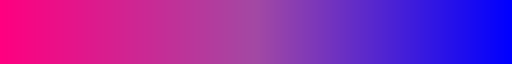

In [329]:
bi

Our first step now is to before solving it, defining our space and time. That is, we need to define the size of our space and the number of divisions. I will define it going from $x_{\min}$ to $x_{\max}$, divided in $n$ steps.

I will also be defining the mean and standard deviation of the gaussian curve for the initial condition, and the value of the $\alpha$ constant.

Finally, I define the final time $t_{\mathrm{final}}$ for the simulation and the time steps as being $\mathrm{d}t = \mathrm{d}x^2/24\alpha$. Why 8? Just because $1/24$ is much smaller than $1/2$, so we will be satisfying the condition

\begin{align}
    \Delta t \leq \frac{\left( \Delta x \right)^2}{2 \alpha}
\end{align}

and indeed

\begin{align}
    \frac{\left( \Delta x \right)^2}{24 \alpha} < \frac{\left( \Delta x \right)^2}{2 \alpha}
\end{align}

In [3]:
x_min = -5
x_max = 5
n = 100
center = 0
sd = 0.4
T1s = 0.1
T2s = 0.1
r = 0.06
k = 0.8
chi = 0.5
gamma = r/k
lambd = 0.1
q = 0.5

dx = (x_max - x_min)/n

D_b = 1e-2
D_s = 5e-2
t_final = 500
dt = dx**2 / (24*D_b)

print(f'Time step: {dt:.2f}')
print(f'Spatial step: {dx:.2f}')

Time step: 0.04
Spatial step: 0.10


In [11]:
# Create the space
x = np.linspace(x_min, x_max, n)

# Create time array
t = np.arange(0, t_final, dt)

In [4]:
# Solving the differential equation
def solve_model(t, rho, S, x_min, x_max, t_max, n, D_s, D_b, chi, r, k, lambd, t_c):
    # Defining the step in space and time
    dx = (x_max - x_min)/n
    dt = dx**2 / (24*D_b)
    # Defining space
    x = np.linspace(x_min, x_max, n)
    # Array of derivatives
    drhodt = np.empty(n)
    dSdt = np.empty(n)
    # Defining time
    t = np.arange(0, t_final, dt)
    
    # Array of solutions for density and concentration
    rhos = [rho]
    Ss = [S]
    tot_rho = [np.sum(rho*dx)]
    tot_S = [np.sum(S*dx)]
    
    # Loop in time
    for i in tqdm(range(len(t))):
        # Loop in space
        for j in range(1,n-1):
            # Substance diffusion and degradetion
            dSdt[j] = D_s*((S[j+1] - S[j])/dx**2 - (S[j]-S[j-1])/dx**2) - lambd*S[j]
            # Chemotaxis
            chem = chi*(((rho[j] - rho[j-1])*(S[j] - S[j-1])/dx**2) + rho[j]*((S[j+1] - 2*S[j] + S[j-1])/dx**2))
            # Growth
            growth = r*rho[j]
            # Competition
            competition = gamma*rho[j]**2
            # Bacterial equation
            drhodt[j] = D_b*((rho[j+1] - rho[j])/dx**2 - (rho[j]-rho[j-1])/dx**2) + chem + growth - competition
        # Boundary conditions
        S_max = S[n-1]
        # S_min = S[0]
        if t[i] < t_c:
            S_min = S[0]
        else:
            S_min = 1
        rho_max = D_b*rho[n-1]/(chi*(S_max - S[n-1]) + D_b)
        rho_min = D_b*rho[0]/(chi*(S[0] - S_min) + D_b)

        drhodt[0] = D_b*((rho[1] - 2*rho[0] + rho_min)/dx**2) + (rho[0] - rho_min)*(S[0] - S_min)/dx**2 + rho[0]*((S[1] - S[0])/dx**2 - (S[0]-S_min)/dx**2) + r*rho[0] - gamma*rho[0]**2
        dSdt[0] = D_s*((S[1] - S[0])/dx**2 - (S[0]-S_min)/dx**2) - lambd*S[0]

        drhodt[n-1] = D_b*((rho_max - rho[n-1])/dx**2 - (rho[n-1]-rho[n-2])/dx**2) + (rho[n-1] - rho[n-2])*(S[n-1] - S[n-2])/dx**2 + rho[n-1]*((S_max - S[n-1])/dx**2 - (S[n-1]-S[n-2])/dx**2) + r*rho[n-1] - gamma*rho[n-1]**2
        dSdt[n-1] = D_s*((S_max - S[n-1])/dx**2 - (S[n-1]-S[n-2])/dx**2) - lambd*S[n-1]
        # Updating
        rho = rho + drhodt*dt
        S = S + dSdt*dt

        rhos.append(rho)
        Ss.append(S)
        tot_rho.append(np.sum(rho*dx))
        tot_S.append(np.sum(S*dx))
        
    return rhos, Ss, tot_rho, tot_S


# Initial condition
# rho = st.norm.pdf(x, center, sd)
# S = st.norm.pdf(x, 0, 0.05)
S = np.zeros(n)
# S[50] = 5
rho = np.random.normal(0.4, 0.1, n)
t = np.arange(0, t_final, dt)

rhos, Ss, tot_rho, tot_S = solve_model(t, rho, S, x_min, x_max, t_final, n, D_s, D_b, chi, r, k, 0.01, 250)

100%|██████████| 12000/12000 [00:10<00:00, 1131.00it/s]


In [5]:
rhos = np.array(rhos)
Ss = np.array(Ss)

In [6]:
(rhos < 0).any()

False

In [7]:
np.where(rhos < 0)

(array([], dtype=int64), array([], dtype=int64))

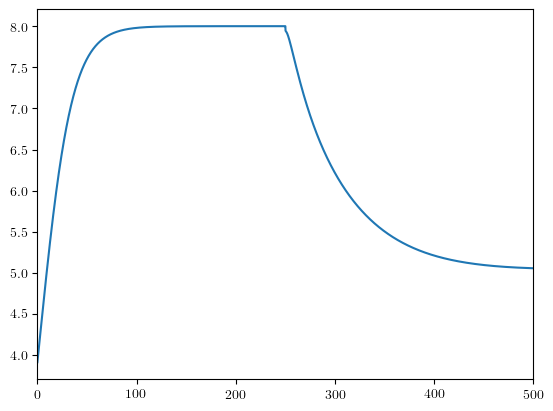

In [10]:
# plt.plot(tot_S)
plt.plot(t, tot_rho[1:])
plt.xlim(0, 500)
plt.show()

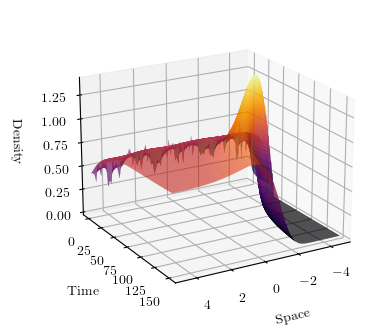

In [255]:
# setup the figure and axes
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(x, t)  # `plot_surface` expects `x` and `y` data to be 2D
ax.plot_surface(X, Y, rhos[1:], cmap = 'inferno', cstride=1, rstride = 1)
# ax.plot_surface(X, Y, Ss[1:], cmap = 'viridis', cstride=1, rstride = 1)

# ax.bar3d(X, T, temos, width, depth, top, shade=True)
# ax.set_title('Shaded')
ax.set_xlabel('Space', labelpad = 8)
ax.set_ylabel('Time', labelpad = 8)
ax.set_zlabel('Density', labelpad = 8)
ax.view_init(elev=20, azim=60)
ax.set_xlim(x[0], x[-1])
plt.show()

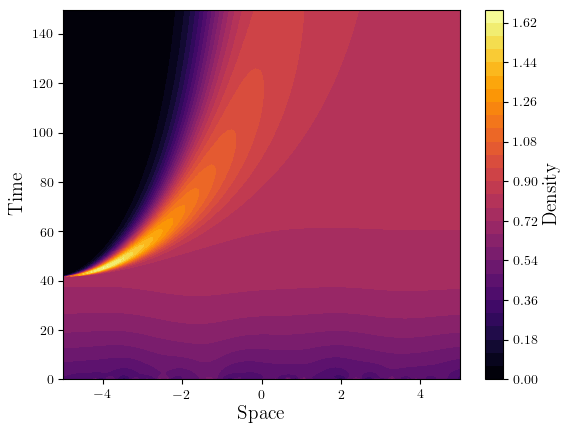

In [321]:
X, Y = np.meshgrid(x, t[:len(rhos)-1])  # `plot_surface` expects `x` and `y` data to be 2D

htmap = plt.contourf(X, Y, rhos[1:], cmap = 'inferno', levels = 30)
cbar = plt.colorbar(htmap, label = 'Density')
cbar.ax.yaxis.get_label().set_fontsize(14)
plt.xlabel('Space', fontsize = 14)
plt.ylabel('Time', fontsize = 14)
# plt.savefig('Plots/Full_model_v1_bacteria.png', dpi = 300, bbox_inches = 'tight')
plt.show()

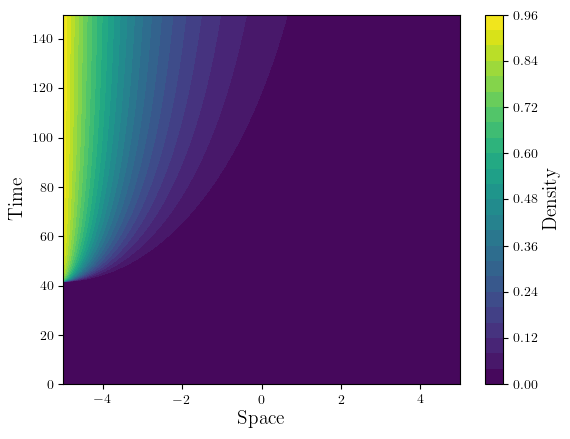

In [322]:
X, Y = np.meshgrid(x, t[:len(rhos)-1])  # `plot_surface` expects `x` and `y` data to be 2D

htmap = plt.contourf(X, Y, Ss[1:], cmap = 'viridis', levels = 30)
cbar = plt.colorbar(htmap, label = 'Density')
cbar.ax.yaxis.get_label().set_fontsize(14)
plt.xlabel('Space', fontsize = 14)
plt.ylabel('Time', fontsize = 14)
# plt.savefig('Plots/Full_model_v1_substance.png', dpi = 300, bbox_inches = 'tight')
plt.show()

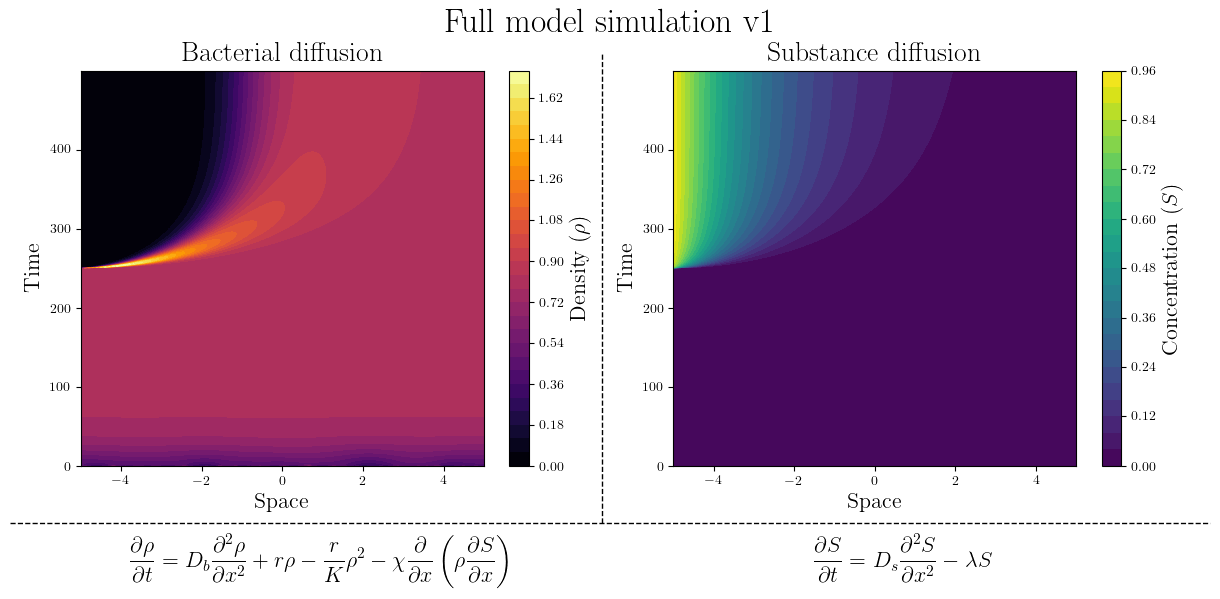

In [12]:
X, Y = np.meshgrid(x, t[:len(rhos)-1])  # `plot_surface` expects `x` and `y` data to be 2D

fig, ax = plt.subplots(1,2, figsize = (12,5))
htmap = ax[0].contourf(X, Y, rhos[1:], cmap = 'inferno', levels = 30)
cbar = plt.colorbar(htmap, label = r'Density ($\rho$)', ax = ax[0])
cbar.ax.yaxis.get_label().set_fontsize(16)
ax[0].set_xlabel('Space', fontsize = 16)
ax[0].set_ylabel('Time', fontsize = 16)
ax[0].set_title('Bacterial diffusion', fontsize = 20)
# ax[0].set_xlim(x[0], x[-1])
# ax[0].set_xticks([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
# ax[0].set_xticklabels([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5], fontsize = 12)

htmap = ax[1].contourf(X, Y, Ss[1:], cmap = 'viridis', levels = 30)
cbar = plt.colorbar(htmap, label = r'Concentration ($S$)', ax = ax[1])
cbar.ax.yaxis.get_label().set_fontsize(16)
ax[1].set_xlabel('Space', fontsize = 16)
ax[1].set_ylabel('Time', fontsize = 16)
ax[1].set_title('Substance diffusion', fontsize = 20)
# ax[1].set_xlim(x[0], x[-1])
# ax[1].set_xticks([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
# ax[1].set_xticklabels([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5], fontsize = 12)

fig.text(0.5, 0.99, 'Full model simulation v1', fontsize = 24, ha = 'center')
fig.add_artist(mpl.lines.Line2D([0.493, 0.493], [0.01, 0.95], color = 'black', lw = 1, ls = '--'))
fig.add_artist(mpl.lines.Line2D([0, 1], [0.01, 0.01], color = 'black', lw = 1, ls = '--'))
fig.text(0.1, -0.08, r"$\displaystyle \frac{\partial \rho}{\partial t} = D_b \frac{\partial^2 \rho}{\partial x^2} + r \rho - \frac{r}{K} \rho^2 - \chi \frac{\partial}{\partial x}\left( \rho \frac{\partial S}{\partial x} \right)$", fontsize = 16)
fig.text(0.67, -0.08, r"$\displaystyle \frac{\partial S}{\partial t} = D_s \frac{\partial^2 S}{\partial x^2} - \lambda S$", fontsize = 16)
plt.tight_layout()
# plt.savefig('Plots/Full_model_v2.png', dpi = 300, bbox_inches = 'tight')
plt.show()

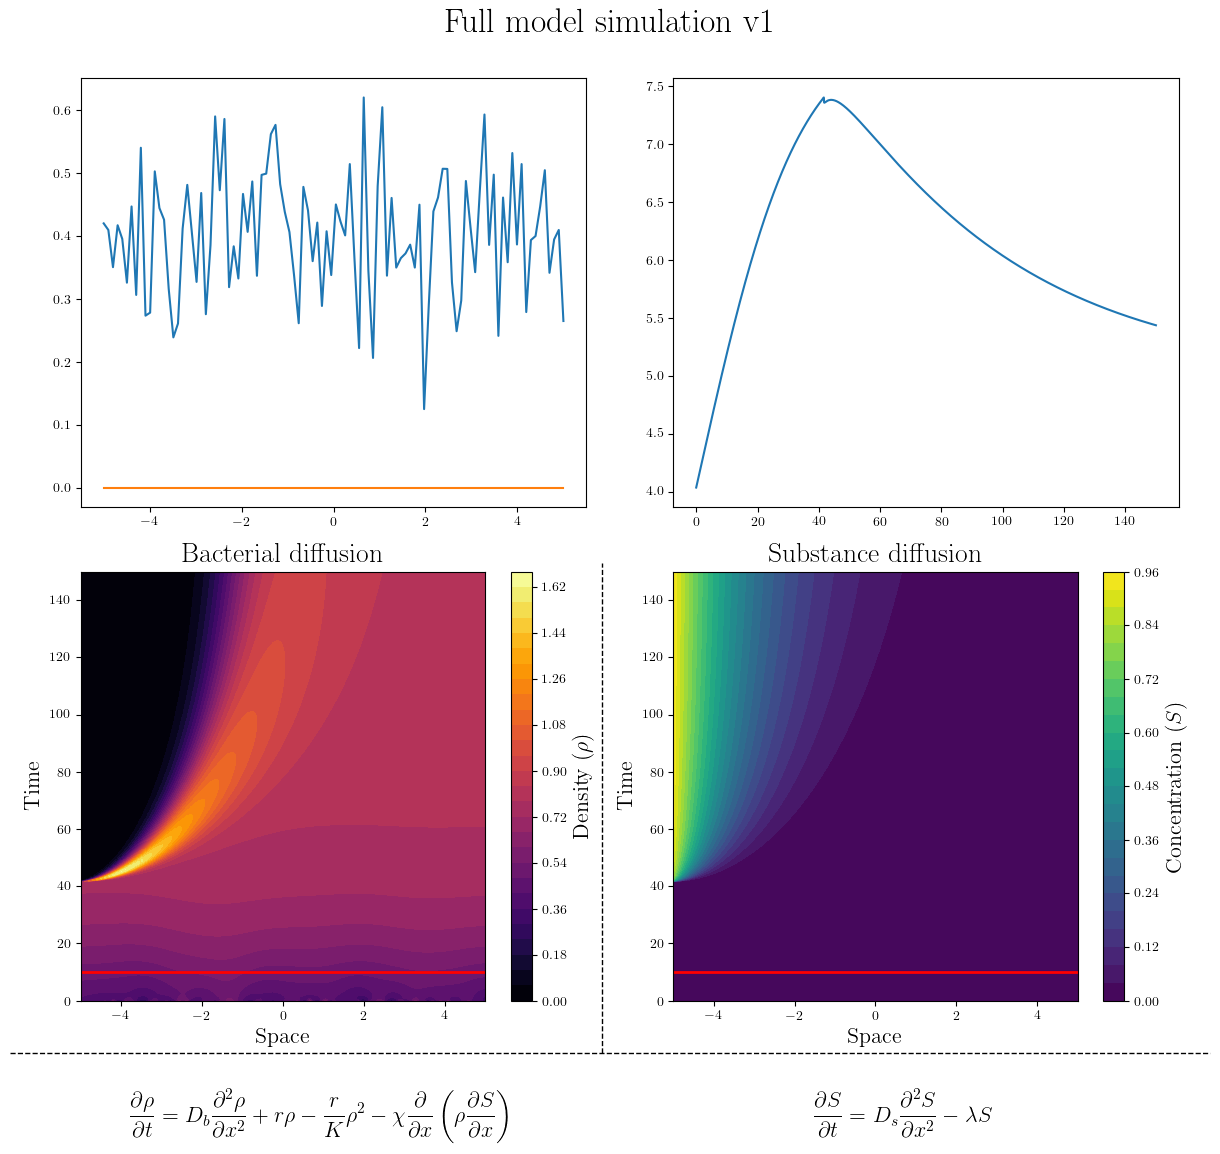

In [340]:
fig, axs = plt.subplots(2, 2, figsize = (12,10))
ax = axs.flatten()
ax[0].plot(x, rhos[0])
ax[0].plot(x, Ss[0])

ax[1].plot(t, tot_rho[1:])

htmap = ax[2].contourf(X, Y, rhos[1:], cmap = 'inferno', levels = 30)
cbar = plt.colorbar(htmap, label = r'Density ($\rho$)', ax = ax[2])
cbar.ax.yaxis.get_label().set_fontsize(16)
ax[2].set_xlabel('Space', fontsize = 16)
ax[2].set_ylabel('Time', fontsize = 16)
ax[2].set_title('Bacterial diffusion', fontsize = 20)
ax[2].axhline(10, color = 'red', lw = 2)

htmap = ax[3].contourf(X, Y, Ss[1:], cmap = 'viridis', levels = 30)
cbar = plt.colorbar(htmap, label = r'Concentration ($S$)', ax = ax[3])
cbar.ax.yaxis.get_label().set_fontsize(16)
ax[3].set_xlabel('Space', fontsize = 16)
ax[3].set_ylabel('Time', fontsize = 16)
ax[3].set_title('Substance diffusion', fontsize = 20)
ax[3].axhline(10, color = 'red', lw = 2)

fig.text(0.5, 1.03, 'Full model simulation v1', fontsize = 24, ha = 'center')
fig.add_artist(mpl.lines.Line2D([0.493, 0.493], [0.01, 0.5], color = 'black', lw = 1, ls = '--'))
fig.add_artist(mpl.lines.Line2D([0, 1], [0.01, 0.01], color = 'black', lw = 1, ls = '--'))
fig.text(0.1, -0.06, r"$\displaystyle \frac{\partial \rho}{\partial t} = D_b \frac{\partial^2 \rho}{\partial x^2} + r \rho - \frac{r}{K} \rho^2 - \chi \frac{\partial}{\partial x}\left( \rho \frac{\partial S}{\partial x} \right)$", fontsize = 16)
fig.text(0.67, -0.06, r"$\displaystyle \frac{\partial S}{\partial t} = D_s \frac{\partial^2 S}{\partial x^2} - \lambda S$", fontsize = 16)
plt.tight_layout()
plt.show()

In [353]:
for i in tqdm(range(len(rhos))):
    if i % 30 == 0:
        
        fig, axs = plt.subplots(2, 2, figsize = (12,10))
        ax = axs.flatten()
        ax[0].plot(x, rhos[i], color = 'teal', zorder = 1, lw = 2, label = 'Bacterial density')
        ax[0].plot(x, Ss[i], color = 'crimson', zorder = 0, lw = 2, label = 'Substance concentration')
        ax[0].axhline(k, lw = 1, ls = '--', color = 'black', label = 'Carrying capacity')
        ax[0].set_xlabel(r'Space ($x$)', fontsize = 16)
        ax[0].set_ylabel(r'Density/Concentration', fontsize = 16)
        ax[0].set_title(f'Time: {t[i-1]:.1f}', fontsize = 20)
        ax[0].set_xlim(x[0], x[-1])
        ax[0].set_ylim(0, 1.5)
        ax[0].legend(loc = 'upper right')

        ax[1].plot(t[:i], tot_rho[1:1+i], lw = 2, color = 'black')
        ax[1].scatter(t[i], tot_rho[1+i], color = 'black')
        ax[1].set_xlim(0, 150)
        ax[1].set_ylim(4, 8)
        ax[1].set_xlabel(r'Time ($t$)', fontsize = 16)
        ax[1].set_ylabel('Total population $N$', fontsize = 16)
        ax[1].set_title('Bacterial population over time', fontsize = 20)

        htmap = ax[2].contourf(X, Y, rhos[1:], cmap = 'inferno', levels = 30)
        cbar = plt.colorbar(htmap, label = r'Density ($\rho$)', ax = ax[2])
        cbar.ax.yaxis.get_label().set_fontsize(16)
        ax[2].set_xlabel(r'Space ($x$)', fontsize = 16)
        ax[2].set_ylabel(r'Time ($t$)', fontsize = 16)
        ax[2].set_title('Bacterial diffusion', fontsize = 20)
        ax[2].axhline(t[i], color = 'red', lw = 2)

        htmap = ax[3].contourf(X, Y, Ss[1:], cmap = 'viridis', levels = 30)
        cbar = plt.colorbar(htmap, label = r'Concentration ($S$)', ax = ax[3])
        cbar.ax.yaxis.get_label().set_fontsize(16)
        ax[3].set_xlabel(r'Space ($x$)', fontsize = 16)
        ax[3].set_ylabel(r'Time ($t$)', fontsize = 16)
        ax[3].set_title('Substance diffusion', fontsize = 20)
        ax[3].axhline(t[i], color = 'red', lw = 2)

        fig.text(0.5, 1.02, 'Full model simulation v1', fontsize = 24, ha = 'center')
        fig.add_artist(mpl.lines.Line2D([0.493, 0.493], [0.01, 0.5], color = 'black', lw = 1, ls = '--'))
        fig.add_artist(mpl.lines.Line2D([0, 1], [0.01, 0.01], color = 'black', lw = 1, ls = '--'))
        fig.add_artist(mpl.lines.Line2D([0, 1], [0.5, 0.5], color = 'black', lw = 1, ls = '--'))
        fig.text(0.1, -0.06, r"$\displaystyle \frac{\partial \rho}{\partial t} = D_b \frac{\partial^2 \rho}{\partial x^2} + r \rho - \frac{r}{K} \rho^2 - \chi \frac{\partial}{\partial x}\left( \rho \frac{\partial S}{\partial x} \right)$", fontsize = 16)
        fig.text(0.67, -0.06, r"$\displaystyle \frac{\partial S}{\partial t} = D_s \frac{\partial^2 S}{\partial x^2} - \lambda S$", fontsize = 16)
        plt.tight_layout()

        plt.savefig(f'Plots/Gifs/Model_chemotaxis_solution_{i}', dpi = 300, bbox_inches = 'tight')
        plt.close()

100%|█████████▉| 3600/3601 [11:21<00:00,  5.28it/s] 


IndexError: index 3600 is out of bounds for axis 0 with size 3600

**Random stuff (ignore it)**

Critical habitat size

\begin{align}
    L_c = \pi \sqrt{\frac{D_b}{r}}
\end{align}

Saturation...

\begin{align}
    \frac{\partial S}{\partial x} \rightarrow \tanh \left( \frac{\partial S}{\partial x} \right)
\end{align}

**Comparisons**

- Crescimento no caso sem quimiotaxia, com quimiotaxia mas sem morte pelo consumo da substancia e com quimiotaxia e morte por consumo da substancia